In [1]:
import numpy as np
import pandas as pd
import pickle

#### Labeled.csv contains the gateway assignment labeled previously by instrumentation engineer. This will serve as the truth for unit classification and a reference for gateway assignement.

In [2]:
#labeled_tags = pd.read_csv("Labeled.csv")

In [3]:
#labeled_tags.head()

#### pickle file is generated by the application itself. Original csv file is imported into dataframe with some location information and then pickled.

In [4]:
file = open("temp_model.pickle",'rb')
df = pickle.load(file)
df.head()

,DWG Number,ASIGateway_label,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,...,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3
0,PID-143,1,NaN,20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,...,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE
1,PID-143,1,NaN,20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,...,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE
2,PID-143,1,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,...,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE
3,PID-143,1,NaN,20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,...,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE
4,PID-143,1,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,...,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE


In [5]:
df.dtypes

DWG Number           object
ASIGateway_label      int32
RLocation            object
Tag                  object
Area                float64
Type                 object
Loop Number         float64
Location            float64
Description          object
Manufacturer        float64
Model Number        float64
Comment             float64
Class Name           object
PnPID                 int64
Area No             float64
Unit No             float64
Supplied By          object
Status               object
Sequence Number     float64
Suffix               object
Instrument Spec     float64
Spec Issued         float64
PO Issued           float64
Signal Type 1        object
Signal Type 2        object
Signal Type 3        object
dtype: object

#### We split the string instrument tag reference location information tagged from the GUI into location columns as lats and lons

In [6]:
lats = []
lons = []

for row in df['RLocation']:
    if type(row) != str:
        lat,lon = (None,None)
    else:
        lat,lon = tuple(str(row).split(','))
        lat = int(lat)
        lon = int(lon)
    lats.append(lat)
    lons.append(lon)
df["Lat"] = lats
df["Long"] = lons 

#### Below array of boolean shows the location of the instrument has been tagged or not

In [7]:
df['RLocation'].notna().head(20)

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7      True
8     False
9      True
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19    False
Name: RLocation, dtype: bool

#### We assign location information to a specific location only dataframe

In [8]:
df_located = df[['RLocation','Lat','Long']][df['RLocation'].notna()]

In [9]:
df_located.describe()

,Lat,Long
count,36.000000,36.000000
mean,376.694444,289.444444
std,157.787528,197.190473
min,264.000000,83.000000
25%,274.000000,115.500000
50%,298.000000,158.500000
75%,537.500000,526.000000
max,771.000000,563.000000


#### We save these location information as X training for DBSCAN to bin locations into units

In [10]:
X = np.array(df_located)
X = X[:,1:3]

In [11]:
X[:20]

array([[271.0, 117.0],
       [274.0, 113.0],
       [271.0, 111.0],
       [275.0, 114.0],
       [273.0, 113.0],
       [268.0, 117.0],
       [771.0, 375.0],
       [769.0, 371.0],
       [769.0, 381.0],
       [540.0, 383.0],
       [542.0, 380.0],
       [539.0, 516.0],
       [537.0, 513.0],
       [546.0, 94.0],
       [548.0, 90.0],
       [546.0, 83.0],
       [300.0, 159.0],
       [298.0, 154.0],
       [293.0, 158.0],
       [301.0, 156.0]], dtype=object)

#### With the location tagging tool used in Tkinter, variation of the location information is introduced by the operator. Instrument Tags location could be contain slight variation of location but is designated to what is meant to be the same exact location. With the semi-filled locations, we will first use a cluster algorithm to group labeled location into its mean location. This effectively bin the exact tagged location for each instrument tag into process units. 

In [12]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


Estimated number of clusters: 7
Estimated number of noise points: 0


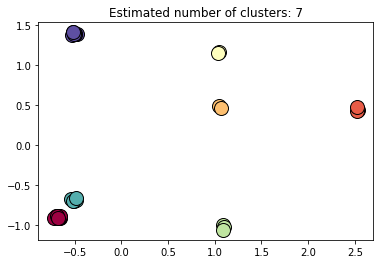

In [13]:
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
# Higher min_samples or lower eps indicate higher density necessary to form a cluster.
db = DBSCAN(eps=0.1, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [14]:
db.labels_

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0])

#### With the small adjustment in eps(cluster radius) and min_sample(minimum cluster size) we were able to group locations into clusters that represent unit. This allow us to bin the locations into each unit.

In [15]:
df_located["unit_label"] = db.labels_

In [16]:
df_located.index

Int64Index([  5,   7,   9,  14,  20,  24,  33,  34,  37,  53,  57,  65,  72,
             79,  82,  84, 103, 112, 114, 142, 158, 172, 199, 201, 216, 220,
            225, 235, 244, 259, 268, 291, 295, 299, 308, 312],
           dtype='int64')

#### We save the unit label information back into the original pickled dataframe

In [17]:
df["unit_label"] = None
df.iloc[df_located.index, -1] = db.labels_

#### We can now use unit_label enumeration as a target variable. This effectively bined the locations into categorical variables. We can use these labeled location now as training set for the machine learning algorithm to classify each intrument tags that is yet to be tagged with location reference into an existing referenced location. This concept serves as a general framework for predicting the location of the instrument tag.

In [18]:
groupby_unit_label_Lat = df[df['Lat'].notnull()].groupby('unit_label').mean()[['Lat','Long']]

In [19]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat':'Lat_mean','Long':'Long_mean'})

In [20]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'unit_label')

#### We assign the centroid or the mean of each cluster into its respective row.

In [21]:
df.iloc[:,:15]

,DWG Number,ASIGateway_label,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,Comment,Class Name,PnPID,Area No
0,PID-143,1,NaN,20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,NaN,FMC Instrument Bubble,831,20.0
1,PID-143,1,NaN,20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,852,20.0
2,PID-143,1,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,NaN,FMC Instrument Bubble,859,20.0
3,PID-143,1,NaN,20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,NaN,FMC Instrument Bubble,899,20.0
4,PID-143,1,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,906,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,1,NaN,20-ZSC-4103G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,NaN,FMC Instrument Bubble,7234,20.0
348,PID-142,1,NaN,20-ZIS-4105K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,NaN,FMC Instrument Bubble,7248,20.0
349,PID-142,1,NaN,20-ZSC/O-4104E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,NaN,FMC Instrument Bubble,7296,20.0
350,PID-142,1,NaN,20-ZIS-4103J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,NaN,FMC Instrument Bubble,7313,20.0


#### We set categorical attributes as dummy variables

In [22]:
df[['Area No','Unit No','Sequence Number']] = df[['Area No','Unit No','Sequence Number']].applymap(str)

In [23]:
df_encoded = pd.get_dummies(df[['DWG Number', 'Area No','Unit No']], prefix=['DWG Number', 'Area No','Unit No'])

In [24]:
normalized_df = df_encoded

In [25]:
normalized_df.shape

(352, 24)

In [26]:
normalized_df.iloc[:,-40:].head()

,DWG Number_PID-101,DWG Number_PID-102,DWG Number_PID-103,DWG Number_PID-111,DWG Number_PID-121,DWG Number_PID-122,DWG Number_PID-123,DWG Number_PID-131,DWG Number_PID-132,DWG Number_PID-133,...,Area No_nan,Unit No_1.0,Unit No_11.0,Unit No_2.0,Unit No_21.0,Unit No_3.0,Unit No_31.0,Unit No_41.0,Unit No_77.0,Unit No_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### We drop the NA rows for rows with tagged location. Then we save the index of these cleaned training rows

In [27]:
train_index = normalized_df[df["RLocation"].notna()].dropna().index
test_index = normalized_df[df["RLocation"].isna()].dropna().index

In [28]:
print(train_index.shape)
test_index.shape

(36,)


(316,)

#### A Breadth of classification algorithms will be tested

In [29]:
from sklearn import tree
model_tree = tree.DecisionTreeClassifier()

#### For KNN we will use jaccard since dummy variables are used. 

In [30]:
from sklearn.neighbors import KNeighborsClassifier
model_knn= KNeighborsClassifier(n_neighbors=3, metric='jaccard')

In [31]:
from sklearn.ensemble import AdaBoostClassifier
model_ab = AdaBoostClassifier(n_estimators=20, learning_rate=1.3)

In [32]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()

In [33]:
from sklearn import svm
model_svm = svm.SVC()

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
model_bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors=3, metric='jaccard'), max_samples=0.5, max_features=0.5,
                           n_estimators=25, random_state=5)

#### For classification of binned location to be accuracy, we will run the set of classification algorithms on a subset of attributes that may be relevant to location information.

### Performance Evaluation

#### Performance will be evaluated based on the actual tagged unit label generated by DBSCAN algorithm. The truth for unit label is contained in labeled_tags dataframe. This will serve as the test set reference truth. For the interest of this specific application, we will test the accuracy of various classification algorithms with respect to varying sparse level of the training set. The user or operator of this application may choose to sparsely tag the instrument location. It is important to test how well each algoritm performs when training set is sparse.

#### The training set will be randomly sampled without replacement from 100%(36 tagged instruments) of tagged data down to 20% of the tagged data. Test set will be automatically reindexed as the rest of the given 352 pre-labeled units from labeled_tags dataframe. Each sparse level level accuracy will be assessed or executed 20 times since random sample of each training subset maybe effect the accuracy of the output. This is observed on high sparse level. Crossvalidated accuracy will be calculated only on training set. This will serve as an indicator to compare how regularized the classification model is compared with the alternative models.

In [35]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.utils.random import sample_without_replacement
from sklearn.model_selection import cross_val_score

In [36]:
#This function Decodes dummy variables back to integer representation
def decodeDummies(y_pred):
    y_pred_arr = []
    y_pred_arr = np.array(y_pred_arr,dtype=str)
    No_Out_list = []
    
    for j, row in enumerate(y_pred):
        for i,v in enumerate(row):
            if v: y_pred_arr = np.append(y_pred_arr,i)
        if sum(row) == 0: 
            #print("nothing at j: " + str(j))
            No_Out_list = np.append(No_Out_list,j)
            y_pred_arr = np.append(y_pred_arr, -1)
    return y_pred_arr, No_Out_list

#This function returns the test set accuracy, contignency matrix, and crossvalidation average accuracy
#for given subset tagged of instrumentation.
def testClassification(df,normalized_df, model, labeled_tags, train_index,test_index):
    X = np.array(normalized_df.iloc[train_index,:])
    y = np.array(pd.get_dummies(df.iloc[train_index,:]["unit_label"]))
    
    cross_val_arr = cross_val_score(model, X, y, cv=int(np.trunc(X.shape[0]/2)), scoring='accuracy')
    #print(cross_val_arr)
    
    fitted_model = model.fit(X, y)
    X_test = np.array(normalized_df.iloc[test_index,:])
    y_pred = fitted_model.predict(X_test)
    
    tst_actual = labeled_tags["Unit_Label"].iloc[test_index].values
    tst_actual = tst_actual.astype(str)
   
    y_pred_arr, No_Out_list = decodeDummies(y_pred)
    
    accuracy = accuracy_score( tst_actual.astype(str), y_pred_arr.astype(str))
    c_matrix = confusion_matrix(tst_actual, y_pred_arr)

    cv_score = sum(cross_val_arr)/len(cross_val_arr)
    #print(accuracy)
    return accuracy, c_matrix, cv_score
    

In [37]:
#Sample Train index with variouse sparse level of user input. 
#Distribute the remaining unsampled index as test index
#Check accuracy at variouse sparse level
def reportAccuracyVersusSparsityOfInput(df,normalized_df, model, labeled_tags, train_index,test_index, percent):
    N_train = train_index.shape[0]
    train_subset_index = sample_without_replacement(N_train,N_train*percent/100)
    subset_train_index = train_index[train_subset_index]
    test_index_updated = set(train_index).union(set(test_index)).difference(set(subset_train_index))
    accuracy, c_matrix, ra_score = testClassification(df,normalized_df, model, labeled_tags, list(subset_train_index),list(test_index_updated))
    return accuracy, ra_score

#This function excutes accuracy test 20 times at each sparse level.
def trySparseRange(df,normalized_df, model, labeled_tags, train_index, test_index):
    accuracy_range = []
    cv_score_range = []
    for percent in range(20,105,5):
        #print("Percent: " + str(percent)+"%")
        run_count = 20
        sum_accuracy = 0
        sum_cv_score = 0
        for i in range(run_count):
            accuracy,cv_score = reportAccuracyVersusSparsityOfInput(df,normalized_df, model_knn, labeled_tags, train_index,test_index,percent)
            sum_accuracy+= accuracy
            sum_cv_score+= cv_score
        #print(sum_accuracy/run_count)
        #print("-"*27)
        accuracy_range.append(sum_accuracy/run_count)
        cv_score_range.append(sum_cv_score/run_count)
    return accuracy_range,cv_score_range

### Evaluate each classifier

In [38]:
#knn_eval = trySparseRange(df,normalized_df, model_knn, labeled_tags, train_index,test_index)
#tree_eval = trySparseRange(df,normalized_df, model_tree, labeled_tags, train_index,test_index)
#rf_eval = trySparseRange(df,normalized_df, model_rf, labeled_tags, train_index,test_index)
#svm_eval = trySparseRange(df,normalized_df, model_svm, labeled_tags, train_index,test_index)
#ab_eval = trySparseRange(df,normalized_df, model_ab, labeled_tags, train_index,test_index)
#bagging_knn_eval = trySparseRange(df,normalized_df, model_bagging_knn, labeled_tags, train_index,test_index)

In [39]:
#pd.DataFrame({'knn_test':knn_eval[0],'knn_xval':knn_eval[1]}, 
#             index=range(20,105,5)).plot(figsize=(16,10), 
#            title='Test Set Accuracy with Various Tagged location Sparse Level')

In [40]:
#pd.DataFrame({'svm_test':svm_eval[0],'svm_xval':svm_eval[1]}, 
#             index=range(20,105,5)).plot(figsize=(16,10), 
#            title='Test Set Accuracy with Various Tagged location Sparse Level')

#### Most likely due to the low number of rows to be fitted and crossvalidated, the train set crossvalidation accuracy is much lower than the accuracy of test set data. When trained on a small set of less than 36 rows of tagged instrument, both KNN and SVM produced accuracy close to 100% in the rest of the test set. Both KNN and SVM are good choice for the classification of location label.

In [41]:
#pd.DataFrame({'knn':knn_eval[0],'rf':rf_eval[0],'svm':svm_eval[0],'ada':ab_eval[0]}, 
#             index=range(20,105,5)).plot(figsize=(16,10), 
#            title='Test Set Accuracy with Various Tagged location Sparse Level')

In [42]:
#pd.DataFrame({'knn':knn_eval[0],'tree':tree_eval[0],'bagging_knn':bagging_knn_eval[0]}, 
#             index=range(20,105,5)).plot(figsize=(16,10), 
#            title='Test Set Accuracy with Various Tagged location Sparse Level')

#### After executing the evaluation functions a number of time, KNN was found to be the most consistent out all classification algorithms.

### Begining of Experiment with Matrix Factorization

#### Below is a experimental attempt to use Matrix Factorization to reconstruct the missing unit information in the full dataset. This is a parallel step to KNN algoritm above with the goal of filling missing location bins.

In [43]:
from sklearn import preprocessing

#### Save index of the full dataset without NA

In [44]:
full_index = normalized_df.dropna().index

In [45]:
full_index.shape

(352,)

In [46]:
unit_label = pd.get_dummies(df.iloc[full_index,:]["unit_label"])

In [47]:
label_arr = np.array(unit_label)

In [48]:
normalized_df.iloc[0,:]

DWG Number_PID-101    0
DWG Number_PID-102    0
DWG Number_PID-103    0
DWG Number_PID-111    0
DWG Number_PID-121    0
DWG Number_PID-122    0
DWG Number_PID-123    0
DWG Number_PID-131    0
DWG Number_PID-132    0
DWG Number_PID-133    0
DWG Number_PID-141    0
DWG Number_PID-142    0
DWG Number_PID-143    1
Area No_20.0          1
Area No_nan           0
Unit No_1.0           0
Unit No_11.0          0
Unit No_2.0           0
Unit No_21.0          0
Unit No_3.0           0
Unit No_31.0          0
Unit No_41.0          0
Unit No_77.0          1
Unit No_nan           0
Name: 0, dtype: uint8

In [49]:
normalized_df.iloc[full_index,:]

,DWG Number_PID-101,DWG Number_PID-102,DWG Number_PID-103,DWG Number_PID-111,DWG Number_PID-121,DWG Number_PID-122,DWG Number_PID-123,DWG Number_PID-131,DWG Number_PID-132,DWG Number_PID-133,...,Area No_nan,Unit No_1.0,Unit No_11.0,Unit No_2.0,Unit No_21.0,Unit No_3.0,Unit No_31.0,Unit No_41.0,Unit No_77.0,Unit No_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [50]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(normalized_df.iloc[full_index,:])
X_full = min_max_scaler.transform(normalized_df.iloc[full_index,:])

In [51]:
X_full

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [52]:
X_full.shape

(352, 24)

In [53]:
label_arr.shape

(352, 7)

In [54]:
X_full.shape[1] + label_arr.shape[1]

31

In [55]:
GradientDescent_Flag_Mat = np.zeros((X_full.shape[0],X_full.shape[1] + label_arr.shape[1]))

In [56]:
GradientDescent_Flag_Mat.shape

(352, 31)

In [57]:
for i, row in enumerate(label_arr):
    if sum(row) == 0:
        GradientDescent_Flag_Mat[X_full.shape[1]+1,:] = True
        GradientDescent_Flag_Mat[i,:X_full.shape[1]] = False
    else:
        GradientDescent_Flag_Mat[i,:] = False
GradientDescent_Flag_Mat[2,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
X_full = np.hstack([X_full,label_arr])

In [59]:
X_full.shape

(352, 31)

In [60]:
def matrix_factorization(R, P, Q, K,Flag_Mat, steps=3000, alpha=0.0002, beta=0.02):
    
    ### R = The user x item rating matrix (m x n)
    ### P = Initial user-factor matrix (m x k)
    ### Q = Initial item-factor matrix (n x k)
    ### K = The number of latent factors (features)
    ### steps = The number of epochs in gradient descent
    ### alpha = The learning rate for gradient descent
    ### beta = The regularization coefficient
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        ### update P and Q based on the partial derivatives
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        print("Step %d of %d; Error: %0.5f; Time: %0.2f" %(step+1, steps, e, time()))
    return P, Q.T

In [61]:
InstrumentInfoMatrix = np.array(X_full)

In [62]:
X_full.shape[1]

31

In [63]:
M = X_full.shape[0]
N = X_full.shape[1]
K = 31
steps = 50

In [64]:
### Initialize P and Q to random values
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

In [65]:
#from time import time
#t0 = time()
#fP, fQ = matrix_factorization(InstrumentInfoMatrix, P, Q, K, GradientDescent_Flag_Mat, steps=steps)
#print("done in %0.3fs." % (time() - t0))

In [66]:
#Preds = np.dot(fP,fQ.T)

In [67]:
#InstrumentInfoMatrix[49]

In [68]:
#a = 1
#for i in range(len(InstrumentInfoMatrix[a,:])):
#    print(InstrumentInfoMatrix[a,i])
#    print(Preds[a,i])
#    print("*"*50)

#### Matrix Factorization did not provide good accuracy in filling the missing labels. This is mainly due to the large amount of errors the gradient descent alogrithm has to accomodate and the lack of degrees of freedom since the matrix is not sparse as an recommendation system.

### End of Experiment

#### Encode(convert dummy variables back to integer) KNN results for back filling location information back to groups

In [69]:
labeled_tags = None
#This function returns the predicted list of tag location group
def runClassification(df,normalized_df, model, labeled_tags, train_index,test_index):
    X = np.array(normalized_df.iloc[train_index,:])
    y = np.array(pd.get_dummies(df.iloc[train_index,:]["unit_label"]))
    fitted_model = model.fit(X, y)
    X_test = np.array(normalized_df.iloc[test_index,:])
    y_pred = fitted_model.predict(X_test)
    return y_pred

In [70]:
y_pred = runClassification(df,normalized_df, model_knn, labeled_tags, train_index,test_index)

In [71]:
for row in y_pred:
    if (sum(row) == 0):
        print("found")

In [72]:
y_pred_arr, No_Out_list = decodeDummies(y_pred)

In [73]:
y_pred_arr.shape

(316,)

In [74]:
[int(i) for i in No_Out_list]

[]

In [75]:
normalized_df.iloc[test_index[[int(i) for i in No_Out_list]],:].iloc[:,10:]

,DWG Number_PID-141,DWG Number_PID-142,DWG Number_PID-143,Area No_20.0,Area No_nan,Unit No_1.0,Unit No_11.0,Unit No_2.0,Unit No_21.0,Unit No_3.0,Unit No_31.0,Unit No_41.0,Unit No_77.0,Unit No_nan


In [76]:
df.iloc[test_index[[int(i) for i in No_Out_list]],:]

,DWG Number,ASIGateway_label,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean


In [77]:
y_pred_arr.shape

(316,)

In [78]:
groupby_unit_label_Lat

,Lat_mean,Long_mean
unit_label,,
0,271.181818,114.363636
1,769.666667,375.666667
2,541.000000,381.500000
3,538.000000,514.500000
4,546.666667,89.000000
5,298.333333,156.666667
6,297.888889,559.555556


In [79]:
groupby_unit_label_Lat.index

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64', name='unit_label')

#### We can now use the predicted unit label to append the location of the instrument

In [80]:
df['pre_unit_label'] = None

In [81]:
df['pre_unit_label'] = pd.Series(y_pred_arr.astype(object),index=test_index)

In [82]:
df.iloc[60,]

DWG Number                        PID-102
ASIGateway_label                        2
RLocation                             NaN
Tag                          20-ZSC-0201B
Area                                  NaN
Type                                  ZSC
Loop Number                           NaN
Location                              NaN
Description              Closed Detection
Manufacturer                          NaN
Model Number                          NaN
Comment                               NaN
Class Name          FMC Instrument Bubble
PnPID                                2013
Area No                              20.0
Unit No                               2.0
Supplied By                 With assembly
Status                                NaN
Sequence Number                       1.0
Suffix                                  B
Instrument Spec                       NaN
Spec Issued                           NaN
PO Issued                             NaN
Signal Type 1                     

In [83]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat_mean':'pre_Lat_mean','Long_mean':'pre_Long_mean'})

In [84]:
groupby_unit_label_Lat

,pre_Lat_mean,pre_Long_mean
unit_label,,
0,271.181818,114.363636
1,769.666667,375.666667
2,541.000000,381.500000
3,538.000000,514.500000
4,546.666667,89.000000
5,298.333333,156.666667
6,297.888889,559.555556


In [85]:
groupby_unit_label_Lat.index = groupby_unit_label_Lat.index.astype(str)

In [86]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'pre_unit_label')

In [87]:
df

,DWG Number,ASIGateway_label,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,...,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean
0,PID-143,1,NaN,20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
1,PID-143,1,NaN,20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
2,PID-143,1,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
3,PID-143,1,NaN,20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
4,PID-143,1,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,1,NaN,20-ZSC-4103G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
348,PID-142,1,NaN,20-ZIS-4105K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
349,PID-142,1,NaN,20-ZSC/O-4104E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,...,DIASI,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636
350,PID-142,1,NaN,20-ZIS-4103J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,...,NONE,NONE,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636


In [88]:
df[['DWG Number', 'RLocation', 'Tag', 'unit_label','pre_unit_label']].iloc[250:300,:]

,DWG Number,RLocation,Tag,unit_label,pre_unit_label
250,PID-132,NaN,20-XY-3105E,None,6
251,PID-132,NaN,20-ZIS-3104K,None,6
252,PID-132,NaN,20-XY-3103A,None,6
253,PID-132,NaN,20-ZIS-3104J,None,6
254,PID-132,NaN,20-ZIS-3105J,None,6
255,PID-132,NaN,20-ZIS-3105K,None,6
256,PID-132,NaN,20-ZSC-3103G,None,6
257,PID-132,NaN,20-XY-3104A,None,6
258,PID-132,NaN,20-ZSC/O-3105E,None,6
259,PID-133,"298,558",20-ZIS-3101J,6,NaN


In [89]:
df.columns

Index(['DWG Number', 'ASIGateway_label', 'RLocation', 'Tag', 'Area', 'Type',
       'Loop Number', 'Location', 'Description', 'Manufacturer',
       'Model Number', 'Comment', 'Class Name', 'PnPID', 'Area No', 'Unit No',
       'Supplied By', 'Status', 'Sequence Number', 'Suffix', 'Instrument Spec',
       'Spec Issued', 'PO Issued', 'Signal Type 1', 'Signal Type 2',
       'Signal Type 3', 'Lat', 'Long', 'unit_label', 'Lat_mean', 'Long_mean',
       'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean'],
      dtype='object')

In [90]:
check_result_df = df[['DWG Number', 'Tag', 'Signal Type 1', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean']]
check_result_df.iloc[100:200,]

,DWG Number,Tag,Signal Type 1,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean
100,PID-121,20-ZIS-2106J,DIASI,NaN,NaN,None,NaN,NaN,5,298.333333,156.666667
101,PID-121,20-XY-2108A,DOASI,NaN,NaN,None,NaN,NaN,5,298.333333,156.666667
102,PID-121,20-ZIS-2108K,DIASI,NaN,NaN,None,NaN,NaN,5,298.333333,156.666667
103,PID-121,20-XY-2108P,DOASI,300.0,159.0,5,298.333333,156.666667,NaN,NaN,NaN
104,PID-121,20-XY-2106E,DOASI,NaN,NaN,None,NaN,NaN,5,298.333333,156.666667
...,...,...,...,...,...,...,...,...,...,...,...
195,PID-131,20-XY-3106P,DOASI,NaN,NaN,None,NaN,NaN,6,297.888889,559.555556
196,PID-131,20-ZSC/O-3107E,DIASI,NaN,NaN,None,NaN,NaN,6,297.888889,559.555556
197,PID-131,20-ZIS-3107K,DIASI,NaN,NaN,None,NaN,NaN,6,297.888889,559.555556
198,PID-131,20-ZSC-3106G,DIASI,NaN,NaN,None,NaN,NaN,6,297.888889,559.555556


In [91]:
combined_location_df = check_result_df[['Lat_mean', 'Long_mean',
       'pre_Lat_mean', 'pre_Long_mean']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [92]:
combined_location_df = combined_location_df.str.split(',',expand=True)

In [93]:
check_result_df[['cL_Lat', 'cL_Long']] = combined_location_df

/home/zhimin90/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [94]:
check_result_df

,DWG Number,Tag,Signal Type 1,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean,cL_Lat,cL_Long
0,PID-143,20-ZSC-7753.,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
1,PID-143,20-XY-4101C,DOASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
2,PID-143,20-ZSC-4101A,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
3,PID-143,20-ZIS-4102K,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
4,PID-143,20-XY-4101E,DOASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,20-ZSC-4103G,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
348,PID-142,20-ZIS-4105K,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
349,PID-142,20-ZSC/O-4104E,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636
350,PID-142,20-ZIS-4103J,DIASI,NaN,NaN,None,NaN,NaN,0,271.181818,114.363636,271.1818181818182,114.36363636363636


In [95]:
plot_df = check_result_df[['Tag','cL_Lat','cL_Long']]

In [96]:
plot_df = plot_df[['cL_Lat', 'cL_Long']].apply(pd.to_numeric)

In [97]:
plot_df

,cL_Lat,cL_Long
0,271.181818,114.363636
1,271.181818,114.363636
2,271.181818,114.363636
3,271.181818,114.363636
4,271.181818,114.363636
...,...,...
347,271.181818,114.363636
348,271.181818,114.363636
349,271.181818,114.363636
350,271.181818,114.363636


In [98]:
plot_bygroup_df = plot_df.groupby(['cL_Lat', 'cL_Long']).size().reset_index(name='count')

In [99]:
plot_bygroup_df

,cL_Lat,cL_Long,count
0,271.181818,114.363636,95
1,297.888889,559.555556,93
2,298.333333,156.666667,91
3,538.000000,514.500000,17
4,541.000000,381.500000,17
5,546.666667,89.000000,22
6,769.666667,375.666667,17


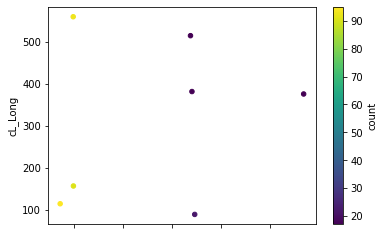

In [100]:
plot_bygroup_df.plot.scatter(x='cL_Lat',y='cL_Long',c='count',colormap='viridis')

In [101]:
plot_df[['cL_Lat', 'cL_Long']].dropna()

,cL_Lat,cL_Long
0,271.181818,114.363636
1,271.181818,114.363636
2,271.181818,114.363636
3,271.181818,114.363636
4,271.181818,114.363636
...,...,...
347,271.181818,114.363636
348,271.181818,114.363636
349,271.181818,114.363636
350,271.181818,114.363636


In [102]:
nonNAN_index = plot_df[['cL_Lat', 'cL_Long']].dropna().index

In [103]:
X = np.array(plot_df.iloc[nonNAN_index,:][['cL_Lat', 'cL_Long']] )

In [104]:
len(nonNAN_index)

352

In [105]:
X[60]

array([541. , 381.5])

In [106]:
X.shape

(352, 2)

In [107]:
type(X[0,0])

numpy.float64

In [108]:
 np.isfinite(X).all()

True

In [109]:
X.shape

(352, 2)

In [110]:
int(np.ceil(X.shape[0]/50))

8

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(np.ceil(X.shape[0]/50)), random_state=0).fit(X)

/home/zhimin90/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  


In [112]:
kmeans.labels_

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

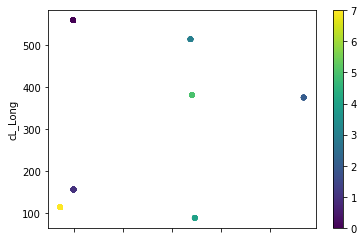

In [113]:
plot_df.iloc[nonNAN_index,:].plot.scatter(x='cL_Lat',y='cL_Long',c=kmeans.labels_,colormap='viridis')

#### KMean cluster does not allow us to set the maximum number of tags per cluster. ASi gateways limits 60 devices per gateway which means there needs to be an inherent maximum point in cluster limit we can allow per cluster. For this, we will modify DBScan clustering algorithm. DBScan algorithm is used since density is already a factor in the algoritm itself. The cluster grow until it reaches the edge.

#### With DBScan algorithm, we can limit the cluster growth once the overall cluster point limit has been reached. We will achieve this by conditionally the FOR loop that handles cluster growth. Once maximum cluster point limit has been reached, we will simply return the unassigned points from the current cluster back to the original neighbor search list. This allows each point to be explored by the algorithm even if they are not an edge to a cluster. 

In [114]:
from dbscan import MyDBSCAN
from sklearn.preprocessing import StandardScaler

In [115]:
X.shape

(352, 2)

In [116]:
X_normalized = StandardScaler().fit_transform(X)

In [117]:
X_normalized

array([[-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [-0.61498156, -0.88348379],
       [ 3.15643376,  0.46012362],
       [ 3.15643376,

#### MaxPts is the maximum number of tags each cluster can hold

In [118]:
print ('Running my implementation...')
my_labels,label_index = np.array(MyDBSCAN(X_normalized, eps=.2, MinPts=20, MaxPts = 100))

Running my implementation...
{}
Growing Cluster
Completed
{1: 96}
Growing Cluster
Completed
{1: 96, 2: 18}
Growing Cluster
Completed
{1: 96, 2: 35}
Growing Cluster
Completed
{1: 96, 2: 52}
Growing Cluster
Completed
{1: 96, 2: 74}
Growing Cluster
{1: 96, 2: 101}
Growing Cluster
Completed
{1: 96, 2: 101, 3: 65}
Growing Cluster
{1: 96, 2: 101, 3: 101}
Growing Cluster
Completed


In [119]:
dict(zip(nonNAN_index,list(zip(label_index,my_labels))))

{0: (0, 1),
 1: (1, 1),
 2: (2, 1),
 3: (3, 1),
 4: (4, 1),
 5: (5, 1),
 6: (6, 1),
 7: (7, 1),
 8: (8, 1),
 9: (9, 1),
 10: (10, 1),
 11: (11, 1),
 12: (12, 1),
 13: (13, 1),
 14: (14, 1),
 15: (15, 1),
 16: (16, 1),
 17: (17, 1),
 18: (18, 1),
 19: (19, 1),
 20: (20, 1),
 21: (21, 1),
 22: (22, 1),
 23: (23, 1),
 24: (24, 1),
 25: (25, 1),
 26: (26, 1),
 27: (95, 2),
 28: (96, 2),
 29: (97, 2),
 30: (98, 2),
 31: (99, 2),
 32: (100, 2),
 33: (101, 2),
 34: (102, 2),
 35: (103, 2),
 36: (104, 2),
 37: (105, 2),
 38: (106, 2),
 39: (107, 2),
 40: (108, 2),
 41: (109, 2),
 42: (110, 2),
 43: (111, 2),
 44: (112, 2),
 45: (113, 2),
 46: (114, 2),
 47: (115, 2),
 48: (116, 2),
 49: (117, 2),
 50: (118, 2),
 51: (119, 2),
 52: (120, 2),
 53: (121, 2),
 54: (122, 2),
 55: (123, 2),
 56: (124, 2),
 57: (125, 2),
 58: (126, 2),
 59: (127, 2),
 60: (128, 2),
 61: (129, 2),
 62: (130, 2),
 63: (131, 2),
 64: (132, 2),
 65: (133, 2),
 66: (134, 2),
 67: (135, 2),
 68: (136, 2),
 69: (137, 2),
 7

In [120]:
core_samples_mask = np.zeros_like(my_labels, dtype=bool)
core_samples_mask[np.array(range(0,len(my_labels)))] = True
labels = my_labels

In [121]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]


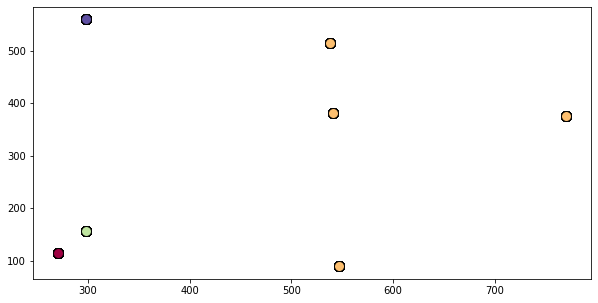

In [122]:
plt.figure(figsize=(10,5)) 
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    #print(k)
    class_member_mask = (my_labels == k)
    #print(my_labels == k)
    xy = X[class_member_mask & core_samples_mask]
    #print(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
    #print(xy)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [123]:
clusterDict = {}
for label in labels:
    if label in clusterDict.keys():
        clusterDict[label] += 1
    else:
        clusterDict[label] = 1

In [124]:
check_result_df.iloc[nonNAN_index,:].shape[1]

13

In [125]:
dbscan_labeled = check_result_df.iloc[nonNAN_index,:]
dbscan_labeled["Gateway_Label"] = my_labels
dbscan_labeled["Gateway_Label_order"] = label_index

In [126]:
clusterDict

{1: 95, 2: 100, 3: 100, 4: 57}

In [127]:
my_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [128]:
label_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 24

#### Taking a closer look at individual cluster grouping

In [129]:
dbscan_labeled[['DWG Number', 'Gateway_Label', 'Tag','unit_label',
       'cL_Lat', 'cL_Long']].sort_values(by=['cL_Lat','cL_Long']).iloc[0:100,:]

,DWG Number,Gateway_Label,Tag,unit_label,cL_Lat,cL_Long
0,PID-143,1,20-ZSC-7753.,None,271.1818181818182,114.36363636363636
1,PID-143,1,20-XY-4101C,None,271.1818181818182,114.36363636363636
2,PID-143,1,20-ZSC-4101A,None,271.1818181818182,114.36363636363636
3,PID-143,1,20-ZIS-4102K,None,271.1818181818182,114.36363636363636
4,PID-143,1,20-XY-4101E,None,271.1818181818182,114.36363636363636
...,...,...,...,...,...,...
193,PID-131,3,20-ZSO-3107H,None,297.8888888888889,559.5555555555555
194,PID-131,3,20-ZIS-3106J,None,297.8888888888889,559.5555555555555
195,PID-131,3,20-XY-3106P,None,297.8888888888889,559.5555555555555
196,PID-131,3,20-ZSC/O-3107E,None,297.8888888888889,559.5555555555555


### Performance Evaluation:

#### The performance of the clustering algorithm can be judged by how close it is to the human generated instrument cluster group. In the program itself, this evaluation will not be part of the learning process. Here in the experimental phase of program development, we wish to evaluate equivalent purpose algorithms in order to choose the best performing algorithm for the final application.

#### Completeness and Homogeneity will be the metrics used to evaluate the effectiveness of the clustering algoritm

In [130]:
from sklearn.metrics import completeness_score, homogeneity_score

#### Compleness and Homogeneity Scores should be based on the ground trueth. In reality, there are many variation of the the trueth. Below set of gateway labels is one variation of the ground truth on how the gateways should be allocated to each tag. We will use these measures to see how similar the custom DBSCAN clustering algorithm is able to get to the engineered solution. 

In [131]:
#labeled_tags["Unit_Label"].values

In [132]:
#dbscan_labeled['Gateway_Label'].values

In [133]:
#completeness_score(labeled_tags["Unit_Label"].values, dbscan_labeled['Gateway_Label'].values)

In [134]:
#homogeneity_score(labeled_tags["Unit_Label"].values, dbscan_labeled['Gateway_Label'].values)

In [135]:
df[['ASIGateway_label','ASIGateway_label_order']] = dbscan_labeled[['Gateway_Label','Gateway_Label_order']]

In [136]:
df.columns

Index(['DWG Number', 'ASIGateway_label', 'RLocation', 'Tag', 'Area', 'Type',
       'Loop Number', 'Location', 'Description', 'Manufacturer',
       'Model Number', 'Comment', 'Class Name', 'PnPID', 'Area No', 'Unit No',
       'Supplied By', 'Status', 'Sequence Number', 'Suffix', 'Instrument Spec',
       'Spec Issued', 'PO Issued', 'Signal Type 1', 'Signal Type 2',
       'Signal Type 3', 'Lat', 'Long', 'unit_label', 'Lat_mean', 'Long_mean',
       'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean',
       'ASIGateway_label_order'],
      dtype='object')

In [137]:
pd.crosstab(df['ASIGateway_label'],df['Signal Type 1'])

Signal Type 1,DIASI,DOASI,I/O
ASIGateway_label,,,
1,59,36,0
2,47,31,15
3,63,37,0
4,35,22,0


In [138]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 110)
pd.set_option('display.width', 110)

In [139]:
import itertools

moduleList = [[4,4],[4,0],[0,4],[2,2],[2,1]]
            #[AC5235,AC5215,AC5233,AC5214,AC2316]
    
#This function takes a dataframe of a unit with its associated instruments,
#it searches for all listed possible configuration from configuration list 
#and returns the the best possible assignment as a dataframe appended with
#Asi address and module chosen
def unitModuleCombinationSearch(df):
    df_len = df.shape[0]
    suffix_no = getSuffixNo(df)
    #Search from the top of the module list
    #Call moduleAssignmentSearch
    #start a breadth first search to find the highest aggregate configuration score
    return recurseHelperFunc(df,moduleList,suffix_no)
        
def recurseHelperFunc(df,moduleList,suffix_no):
    print("df.index: " + str(df.index))
    scoreList = []
    
    for module in moduleList:
        combinationList = moduleAssignmentSearch(df['Signal Type 1'],module,suffix_no)
        if not len(combinationList) == 0:
            score = combinationList[0][0] #top of the best scored index position
            scoreList.append((score,module,combinationList[0][1]))
            
    bestModuleConfig = sorted(scoreList, key=lambda x: x[0], reverse=True)[0]
    config_index = [df.index[i] for i in bestModuleConfig[2]]
    #print(df.index,config_index)
    #print(sorted(scoreList, key=lambda x: x[0], reverse=True)[0:10])
    #print("best module is: " + str(bestModuleConfig[1]))
    
    remainingRows = Diff(list(df.index),config_index)
    if len(remainingRows) == 0:
        print("Config Combination Found!")
        module_id = 0
        return([(config_index, module_id, bestModuleConfig[1])])
        
    prevBestModule = recurseHelperFunc(df.loc[remainingRows,:],moduleList,suffix_no)
    
    #prevBestModule = found_index, module_id, prevModuleConfig
    #print(prevBestModule)
    module_id = prevBestModule[-1][1]
    curBestModule = (config_index, module_id+1, bestModuleConfig[1])
    return prevBestModule + [curBestModule]
     
def Diff(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif 

def getSuffixNo(df):
    #print("count: " +str(df['Suffix'].value_counts()))
    #print("mode: "+str(df['Suffix'].value_counts().mode().values[0]))
    if len(df['Suffix'].value_counts().mode().values) == 0:
        return 1
    if df['Suffix'].value_counts().mode().values[0]:
        return df['Suffix'].value_counts().mode().values[0]
    else:
        return 1

In [140]:
#module_config => [numberoftype1IO,numberoftype2IO,...]
#suffix_no is the number of instrument tag witht the same suffix
def moduleAssignmentSearch(df,module_config,suffix_no):
    #print("index: " + str(df.index))
    shift = 0
    df_len = df.shape[0]
    numOfIndex = int(df_len/suffix_no)
    configPositions = range(0,numOfIndex)
    noOfPossiblePosition = int(sum(module_config)/suffix_no)
    listOfList = []
    
    for comb in itertools.combinations(list(configPositions),noOfPossiblePosition):
        #print(comb)
        indexOfIndex = []
        for index in comb:
            for member in range(0,suffix_no):
                indexOfIndex.append(index*suffix_no+member)
        #print(indexOfIndex)
        listOfCurrSelRows = [df.index[i] for i in indexOfIndex]
        listOfList.append(indexOfIndex)
        #print(listOfCurrSelRows)
    
    ValidConfigList = []
    for comb in listOfList:
        #print(comb)
        curr_config = np.array(df.iloc[comb].value_counts())
        configurationValidity,configurationScore = checkConfig(module_config,curr_config)
        if configurationValidity:
            #print("config found!")
            #print("score: " + str(configurationScore))
            ValidConfigList.append((configurationScore,comb))
        else:
            pass
            #print("config failed!")
            
    if (sum(module_config) > df.shape[0]):
        curr_config = np.array(df.value_counts())
        configurationValidity,configurationScore = checkConfigRemainder(module_config,curr_config)
        if configurationValidity:
            return [(configurationScore,list(range(0,df.shape[0])))]
        else:
            return [(-9999,[])]
    
    bestConfigList = sorted(ValidConfigList, key=lambda x: x[0], reverse=True)
    return bestConfigList

def checkConfig(setConfig, currentConfig):
    score = 0 #zero is a perfect score
    if (len(setConfig) != len(currentConfig)):
        return False, None
    for i,config in enumerate(setConfig):
        if ((config - currentConfig[i]) > 1) or (currentConfig[i] > config):
            return False, None
        score -= abs(config - currentConfig[i])
    return True,score

def checkConfigRemainder(setConfig, currentConfig):
    #print(setConfig, currentConfig)
    score = 0 #zero is a perfect score

    for i,config in enumerate(currentConfig):
        if (config - setConfig[i]) > 0:
            return False, None
        score -= abs(config - setConfig[i])/10 #a small penalty to find the best module
    if len(currentConfig)<len(setConfig):
        #print("in Penalty")
        #print("len(currentConfig)"+str(len(currentConfig)))
        #print("setConfig[len(currentConfig):-1]" + str(setConfig[len(currentConfig):]))
        for diff in setConfig[len(currentConfig):]:
            score -= diff/10
    return True,score


In [141]:
df["moduleConfig"] = None
df["moduleId"] = None
df["ASiAddress"] = None

In [142]:
def increASI(address):
    letter = address[-1]
    if len(address) == 2:
        num = int(address[0])
    else:
        num = int(address[0:2])
    
    if (letter == 'A'):
        return (str(num)+'B')
    else:
        return (str(num+1)+letter)

In [143]:
for df_group in df.groupby(['ASIGateway_label']):
    unit_group = df_group[1][['Unit No','Sequence Number','ASIGateway_label_order']].groupby(['Unit No','Sequence Number']).agg({'ASIGateway_label_order':['mean']})
    unit_group.columns = ['_'.join(col).strip() for col in unit_group.columns.values]
    IO_List = df_group[1][['DWG Number','ASIGateway_label','Tag',
                           'Unit No','Type','Sequence Number','Suffix',
                           'ASIGateway_label_order', 'Description', 
                           'RLocation', 'Signal Type 1']].sort_values(by=['Unit No',
                                                                          'Sequence Number',
                                                                          'Type','Signal Type 1',
                                                                          'ASIGateway_label_order'])
    ASiAddress = '1A'
    ASiEnumeration = 0
    sorted_list = pd.merge(IO_List, unit_group, left_on=['Unit No','Sequence Number'], right_index=True).sort_values(by=['ASIGateway_label_order_mean','Type','Signal Type 1'])
    #print(sorted_list)
    for unit_no, sequence_no in sorted_list.groupby(['Unit No','Sequence Number']):
        print((unit_no, sequence_no)[0])
        #print((unit_no, sequence_no)[1])
        unit_df = (unit_no, sequence_no)[1]
        print(unit_df['Signal Type 1'].value_counts())
        print(unit_df.sort_values(by=['Suffix','Signal Type 1']))
        unit_sorted = unit_df.sort_values(by=['Suffix','Signal Type 1'])
        config = unitModuleCombinationSearch(unit_sorted)
        print("config: " + str(config))
        for row in config:
            print(row[0])
            df.loc[np.array(row[0]),'moduleConfig']= str(row[2])
            df.loc[np.array(row[0]),'ASiAddress'] = ASiAddress
            ASiAddress = increASI(ASiAddress)
            df.loc[np.array(row[0]),'moduleId'] = ASiEnumeration
            ASiEnumeration += 1
        #moduleAssignmentSearch(unit_sorted['Signal Type 1'],[4,4],2)
        #print(unit_sorted.iloc[0:8,:]['Signal Type 1'].value_counts())
        print('-'*100)
        
    #print(IO_List)

('41.0', '1.0')
DIASI    8
DOASI    6
Name: Signal Type 1, dtype: int64
   DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
2     PID-143                 1    20-ZSC-4101A    41.0    ZSC             1.0      A   
15    PID-143                 1     20-XY-4101A    41.0     XY             1.0      A   
24    PID-143                 1    20-ZSC-4101B    41.0    ZSC             1.0      B   
6     PID-143                 1     20-XY-4101B    41.0     XY             1.0      B   
8     PID-143                 1    20-ZSC-4101C    41.0    ZSC             1.0      C   
1     PID-143                 1     20-XY-4101C    41.0     XY             1.0      C   
10    PID-143                 1    20-ZSC-4101D    41.0    ZSC             1.0      D   
25    PID-143                 1     20-XY-4101D    41.0     XY             1.0      D   
17    PID-143                 1  20-ZSC/O-4101E    41.0  ZSC/O             1.0      E   
4     PID-143                 1     20

df.index: Int64Index([335, 350, 320], dtype='int64')
Config Combination Found!
config: [([335, 350, 320], 0, [4, 0]), ([339, 337, 342, 333, 346, 343, 347, 341], 1, [4, 4])]
[335, 350, 320]
[339, 337, 342, 333, 346, 343, 347, 341]
----------------------------------------------------------------------------------------------------
('41.0', '4.0')
DIASI    7
DOASI    4
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
332    PID-142                 1    20-ZSC-4104A    41.0    ZSC             4.0      A   
334    PID-142                 1     20-XY-4104A    41.0     XY             4.0      A   
349    PID-142                 1  20-ZSC/O-4104E    41.0  ZSC/O             4.0      E   
322    PID-142                 1     20-XY-4104E    41.0     XY             4.0      E   
325    PID-142                 1  20-ZSC/O-4104F    41.0  ZSC/O             4.0      F   
328    PID-142                 1     20-XY-4104F    41.0 

df.index: Int64Index([304, 303, 314], dtype='int64')
Config Combination Found!
config: [([304, 303, 314], 0, [4, 0]), ([307, 295, 306, 308, 286, 305, 298, 318], 1, [4, 4])]
[304, 303, 314]
[307, 295, 306, 308, 286, 305, 298, 318]
----------------------------------------------------------------------------------------------------
('41.0', '7.0')
DIASI    7
DOASI    4
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
309    PID-141                 1    20-ZSC-4107A    41.0    ZSC             7.0      A   
289    PID-141                 1     20-XY-4107A    41.0     XY             7.0      A   
290    PID-141                 1  20-ZSC/O-4107E    41.0  ZSC/O             7.0      E   
299    PID-141                 1     20-XY-4107E    41.0     XY             7.0      E   
300    PID-141                 1  20-ZSC/O-4107F    41.0  ZSC/O             7.0      F   
317    PID-141                 1     20-XY-4107F    41.0 

----------------------------------------------------------------------------------------------------
('11.0', '1.0')
I/O    4
Name: Signal Type 1, dtype: int64
   DWG Number  ASIGateway_label            Tag Unit No  Type Sequence Number Suffix  ASIGateway_label_order  \
86    PID-111                 2  20-X1FV-1101A    11.0  X1FV             1.0      A                     154   
98    PID-111                 2  20-X1FV-1101B    11.0  X1FV             1.0      B                     166   
91    PID-111                 2  20-X1FV-1101C    11.0  X1FV             1.0      C                     159   
89    PID-111                 2   20-XPL-1101?    11.0   XPL             1.0    NaN                     157   

                                  Description RLocation Signal Type 1  ASIGateway_label_order_mean  
86  Xpress Mfld Crossover Valve w/ 1 Pig Stop       NaN           I/O                        159.0  
98  Xpress Mfld Crossover Valve w/ 1 Pig Stop       NaN           I/O             

df.index: Int64Index([125], dtype='int64')
Config Combination Found!
config: [([125], 0, [2, 1]), ([105, 113, 117, 104, 114, 111, 100, 112], 1, [4, 4])]
[125]
[105, 113, 117, 104, 114, 111, 100, 112]
----------------------------------------------------------------------------------------------------
('21.0', '7.0')
DIASI    6
DOASI    3
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
121    PID-121                 2    20-ZSC-2107A    21.0    ZSC             7.0      A   
108    PID-121                 2     20-XY-2107A    21.0     XY             7.0      A   
107    PID-121                 2  20-ZSC/O-2107E    21.0  ZSC/O             7.0      E   
126    PID-121                 2     20-XY-2107E    21.0     XY             7.0      E   
119    PID-121                 2  20-ZSC/O-2107F    21.0  ZSC/O             7.0      F   
115    PID-121                 2    20-ZSC-2107G    21.0    ZSC             7.0      G 

Config Combination Found!
config: [([78, 80, 81, 82, 87, 90, 94], 0, [4, 4])]
[78, 80, 81, 82, 87, 90, 94]
----------------------------------------------------------------------------------------------------
('21.0', '1.0')
DIASI    8
DOASI    6
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
185    PID-123                 3    20-ZSC-2101A    21.0    ZSC             1.0      A   
186    PID-123                 3     20-XY-2101A    21.0     XY             1.0      A   
176    PID-123                 3    20-ZSC-2101B    21.0    ZSC             1.0      B   
192    PID-123                 3     20-XY-2101B    21.0     XY             1.0      B   
171    PID-123                 3    20-ZSC-2101C    21.0    ZSC             1.0      C   
174    PID-123                 3     20-XY-2101C    21.0     XY             1.0      C   
187    PID-123                 3    20-ZSC-2101D    21.0    ZSC             1.0      D   


df.index: Int64Index([154, 153, 155], dtype='int64')
Config Combination Found!
config: [([154, 153, 155], 0, [4, 0]), ([163, 152, 164, 138, 145, 144, 141, 159], 1, [4, 4])]
[154, 153, 155]
[163, 152, 164, 138, 145, 144, 141, 159]
----------------------------------------------------------------------------------------------------
('21.0', '4.0')
DIASI    7
DOASI    4
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
148    PID-122                 3    20-ZSC-2104A    21.0    ZSC             4.0      A   
140    PID-122                 3     20-XY-2104A    21.0     XY             4.0      A   
151    PID-122                 3  20-ZSC/O-2104E    21.0  ZSC/O             4.0      E   
137    PID-122                 3     20-XY-2104E    21.0     XY             4.0      E   
162    PID-122                 3  20-ZSC/O-2104F    21.0  ZSC/O             4.0      F   
142    PID-122                 3     20-XY-2104F    21.0 

df.index: Int64Index([205, 194, 220], dtype='int64')
Config Combination Found!
config: [([205, 194, 220], 0, [4, 0]), ([212, 199, 200, 204, 218, 219, 198, 195], 1, [4, 4])]
[205, 194, 220]
[212, 199, 200, 204, 218, 219, 198, 195]
----------------------------------------------------------------------------------------------------
('31.0', '7.0')
DIASI    7
DOASI    4
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
203    PID-131                 3    20-ZSC-3107A    31.0    ZSC             7.0      A   
216    PID-131                 3     20-XY-3107A    31.0     XY             7.0      A   
196    PID-131                 3  20-ZSC/O-3107E    31.0  ZSC/O             7.0      E   
223    PID-131                 3     20-XY-3107E    31.0     XY             7.0      E   
202    PID-131                 3  20-ZSC/O-3107F    31.0  ZSC/O             7.0      F   
209    PID-131                 3     20-XY-3107F    31.0 

df.index: Int64Index([283, 263, 260], dtype='int64')
Config Combination Found!
config: [([283, 263, 260], 0, [4, 0]), ([265, 278, 267, 268, 281, 276, 275, 277], 1, [4, 4])]
[283, 263, 260]
[265, 278, 267, 268, 281, 276, 275, 277]
----------------------------------------------------------------------------------------------------
('31.0', '3.0')
DIASI    6
DOASI    4
Name: Signal Type 1, dtype: int64
    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
252    PID-132                 4     20-XY-3103A    31.0     XY             3.0      A   
247    PID-132                 4  20-ZSC/O-3103E    31.0  ZSC/O             3.0      E   
243    PID-132                 4     20-XY-3103E    31.0     XY             3.0      E   
234    PID-132                 4  20-ZSC/O-3103F    31.0  ZSC/O             3.0      F   
244    PID-132                 4     20-XY-3103F    31.0     XY             3.0      F   
256    PID-132                 4    20-ZSC-3103G    31.0 

In [144]:
for df_group in df.groupby(['ASIGateway_label']):
    unit_group = df_group[1][['Unit No','Sequence Number','ASIGateway_label_order']].groupby(['Unit No','Sequence Number']).agg({'ASIGateway_label_order':['mean']})
    unit_group.columns = ['_'.join(col).strip() for col in unit_group.columns.values]
    IO_List = df_group[1][['DWG Number','ASIGateway_label','Tag',
                           'Unit No','Type','Sequence Number','Suffix',
                           'ASIGateway_label_order', 'Description','moduleConfig','moduleId', 
                           'Signal Type 1']].sort_values(by=['Unit No',
                                                                          'Sequence Number',
                                                                          'Type','Signal Type 1',
                                                                          'ASIGateway_label_order'])
    sorted_list = pd.merge(IO_List, unit_group, left_on=['Unit No','Sequence Number'], right_index=True).sort_values(by=['Unit No',
                                                                          'Sequence Number',
                                                                          'Type','Signal Type 1',])
    print(sorted_list)

    DWG Number  ASIGateway_label             Tag Unit No   Type Sequence Number Suffix  \
1      PID-143                 1     20-XY-4101C    41.0     XY             1.0      C   
4      PID-143                 1     20-XY-4101E    41.0     XY             1.0      E   
6      PID-143                 1     20-XY-4101B    41.0     XY             1.0      B   
13     PID-143                 1    20-XY-2101F?    41.0     XY             1.0      F   
15     PID-143                 1     20-XY-4101A    41.0     XY             1.0      A   
25     PID-143                 1     20-XY-4101D    41.0     XY             1.0      D   
22     PID-143                 1    20-ZIS-4101J    41.0    ZIS             1.0      J   
23     PID-143                 1    20-ZIS-4101K    41.0    ZIS             1.0      K   
2      PID-143                 1    20-ZSC-4101A    41.0    ZSC             1.0      A   
8      PID-143                 1    20-ZSC-4101C    41.0    ZSC             1.0      C   
10     PID

In [145]:
df.columns

Index(['DWG Number', 'ASIGateway_label', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number', 'Location',
       'Description', 'Manufacturer', 'Model Number', 'Comment', 'Class Name', 'PnPID', 'Area No', 'Unit No',
       'Supplied By', 'Status', 'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued', 'PO Issued',
       'Signal Type 1', 'Signal Type 2', 'Signal Type 3', 'Lat', 'Long', 'unit_label', 'Lat_mean',
       'Long_mean', 'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean', 'ASIGateway_label_order',
       'moduleConfig', 'moduleId', 'ASiAddress'],
      dtype='object')

In [146]:
exportDF = df[['DWG Number', 'ASIGateway_label', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number', 'Location',
       'Description', 'Manufacturer', 'Model Number', 'Comment', 'Class Name', 'PnPID', 'Area No', 'Unit No',
       'Supplied By', 'Status', 'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued', 'PO Issued',
       'Signal Type 1', 'Signal Type 2', 'Signal Type 3','ASiAddress',
       'ASIGateway_label_order', 'moduleConfig','moduleId']].sort_values(by=['ASIGateway_label','moduleId','Unit No','Sequence Number'])
exportDF

,DWG Number,ASIGateway_label,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,Comment,Class Name,PnPID,Area No,Unit No,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,ASiAddress,ASIGateway_label_order,moduleConfig,moduleId
22,PID-143,1,NaN,20-ZIS-4101J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,NaN,FMC Instrument Bubble,1207,20.0,41.0,With assembly,NaN,1.0,J,NaN,NaN,NaN,DIASI,NONE,NONE,1A,22,"[2, 1]",0
23,PID-143,1,NaN,20-ZIS-4101K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,NaN,FMC Instrument Bubble,1215,20.0,41.0,With assembly,NaN,1.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,1A,23,"[2, 1]",0
4,PID-143,1,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,906,20.0,41.0,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE,1B,4,"[2, 2]",1
13,PID-143,1,NaN,20-XY-2101F?,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,1033,20.0,41.0,With assembly,NaN,1.0,F,NaN,NaN,NaN,DOASI,NONE,NONE,1B,13,"[2, 2]",1
17,PID-143,1,NaN,20-ZSC/O-4101E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,NaN,FMC Instrument Bubble,1137,20.0,41.0,NaN,NaN,1.0,E,NaN,NaN,NaN,DIASI,DIASI,NONE,1B,17,"[2, 2]",1
18,PID-143,1,NaN,20-ZSC/O-4101F,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,NaN,FMC Instrument Bubble,1169,20.0,41.0,NaN,NaN,1.0,F,NaN,NaN,NaN,DIASI,DIASI,NONE,1B,18,"[2, 2]",1
1,PID-143,1,NaN,20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,852,20.0,41.0,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE,2B,1,"[4, 4]",2
2,PID-143,1,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,NaN,FMC Instrument Bubble,859,20.0,41.0,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE,2B,2,"[4, 4]",2
6,PID-143,1,NaN,20-XY-4101B,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,NaN,General Instrument Symbol,922,20.0,41.0,With assembly,NaN,1.0,B,NaN,NaN,NaN,DOASI,NONE,NONE,2B,6,"[4, 4]",2
8,PID-143,1,NaN,20-ZSC-4101C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,NaN,FMC Instrument Bubble,938,20.0,41.0,With assembly,NaN,1.0,C,NaN,NaN,NaN,DIASI,NONE,NONE,2B,8,"[4, 4]",2


In [147]:
exportDF.columns

Index(['DWG Number', 'ASIGateway_label', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number', 'Location',
       'Description', 'Manufacturer', 'Model Number', 'Comment', 'Class Name', 'PnPID', 'Area No', 'Unit No',
       'Supplied By', 'Status', 'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued', 'PO Issued',
       'Signal Type 1', 'Signal Type 2', 'Signal Type 3', 'ASiAddress', 'ASIGateway_label_order',
       'moduleConfig', 'moduleId'],
      dtype='object')

In [148]:
exportDF[['DWG Number', 'ASIGateway_label', 'Tag', 'Description',
       'Signal Type 1', 'ASiAddress', 'ASIGateway_label_order',
       'moduleConfig', 'moduleId']].to_csv(r'IO_List.csv', index = False)